In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
from fpm_0 import make_model
# from fpm_01 import make_model
# from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


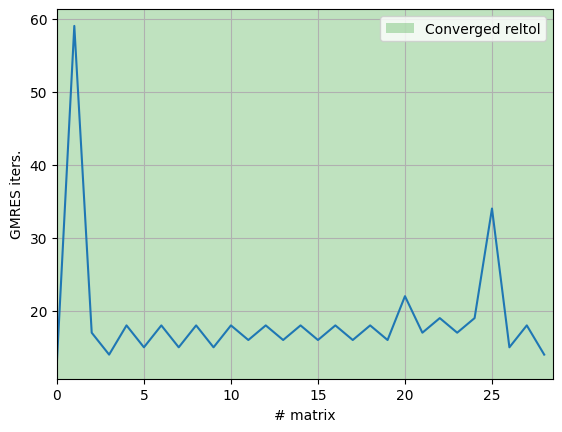

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

18

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 14
sliding = 0
open = 0
transition = 14
total = 14


In [6]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.08
True residual decrease: 0.00011745614823625699


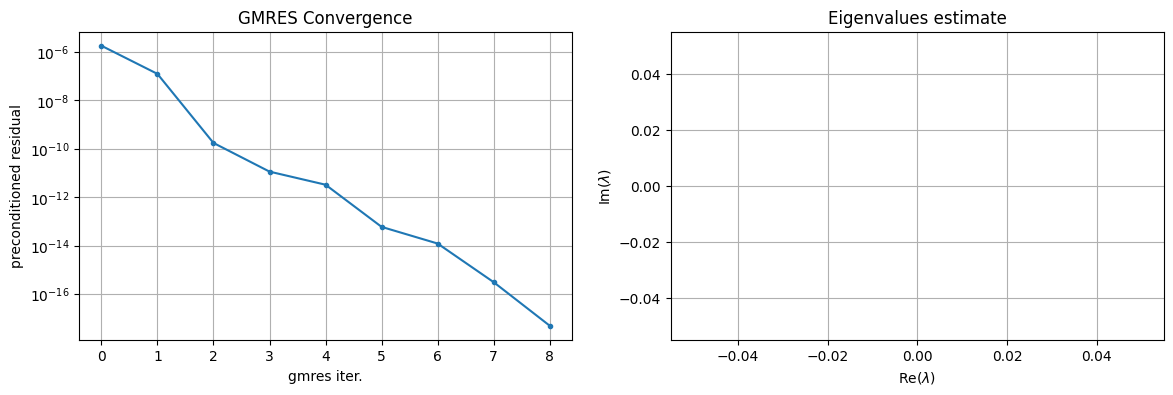

In [7]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

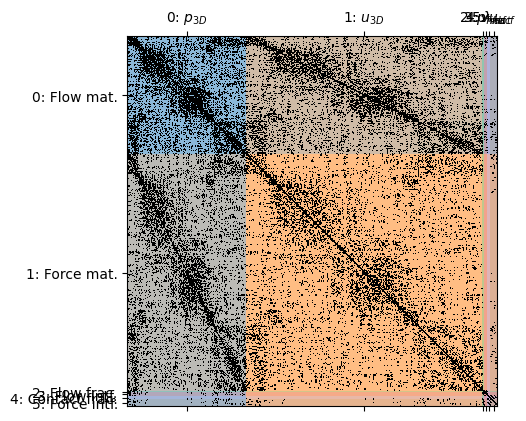

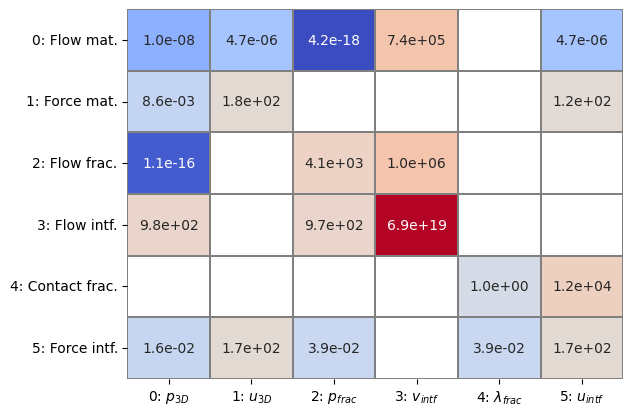

In [8]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

## How exactly can direct solver solve it?

In [9]:
Jinv = inv(J.mat)

In [10]:
x = Jinv @ rhs
norm(J.mat @ x - rhs) / norm(rhs)

0.00022737868114440732

Solve  took: 0.2
True residual decrease: 0.00016633692489574745


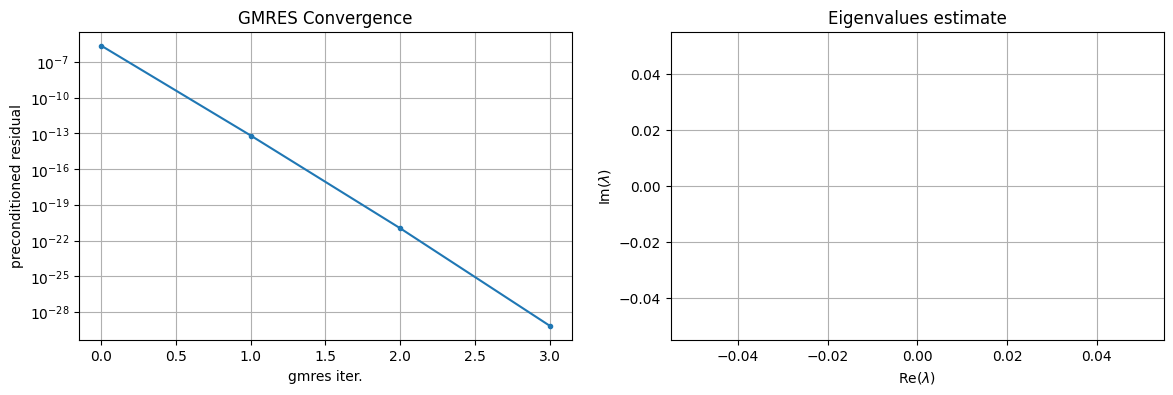

In [11]:
solve_petsc(J.mat, Jinv, J.local_rhs(rhs), tol=1e-21)

# How is stabilized matrix different from the original one?

## Mechanics only

In [12]:
Jmech = J[[1,4,5]]

Jmech_stab = Jmech.copy()
J55_inv = inv_block_diag(Jmech_stab[[5]].mat, nd=model.nd)
Jmech_stab[[4]] = Jmech_stab[[4]].mat - Jmech_stab[4, 5].mat @ J55_inv @ Jmech_stab[5, 4].mat

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [13]:
Jmech_inv = inv(Jmech.mat)
print(cond(Jmech_inv @ Jmech_stab.mat))
print(cond(Jmech_stab.mat @ Jmech_inv))

1.4103380087890383
616795.6257865626


In [14]:
Jmech_stab_inv = inv(Jmech_stab.mat)
print(cond(Jmech_stab_inv @ Jmech.mat))
print(cond(Jmech.mat @ Jmech_stab_inv))

1.4103380087890505
616795.6257850508


Solve  took: 0.18
True residual decrease: 2.6519656781461653e-10


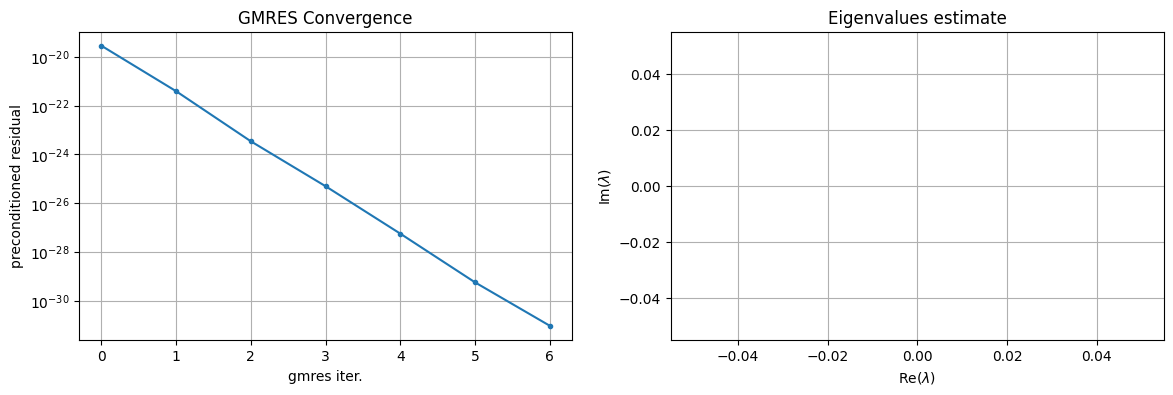

In [15]:
solve_petsc(Jmech.mat, Jmech_stab_inv, rhs=Jmech.local_rhs(rhs))

Solve  took: 0.19
True residual decrease: 2.2774261964693243e-10


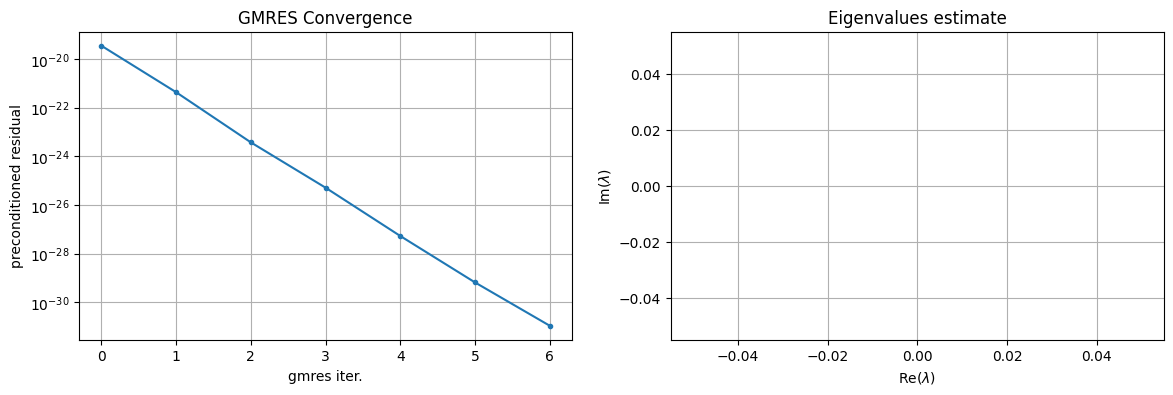

In [16]:
solve_petsc(Jmech_stab.mat, Jmech_inv, rhs=Jmech.local_rhs(rhs))

## What changes with the flow?

In [17]:
Jfm = J[[2,1,4,5]]

Jfm_stab = Jfm.copy()
Jfm_stab[[4]] = Jfm_stab[[4]].mat - Jfm_stab[4, 5].mat @ J55_inv @ Jfm_stab[5, 4].mat

In [18]:
Jfm_inv = inv(Jfm.mat)
print(cond(Jfm_inv @ Jfm_stab.mat))
print(cond(Jfm_stab.mat @ Jfm_inv))

1.410338071745097
4.7654035797243776e+20


In [19]:
Jfm_stab_inv = inv(Jfm_stab.mat)
print(cond(Jfm_stab_inv @ Jfm.mat))
print(cond(Jfm.mat @ Jfm_stab_inv))

1.411319517564528
4.714717994637599e+20


/home/porepy/simulations/plot_utils.py:104: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


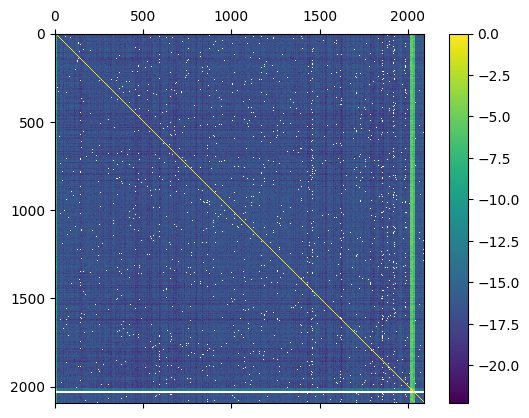

In [20]:
res = Jfm_stab.empty_container()
res.mat = Jfm_stab_inv @ Jfm.mat
res.matshow()

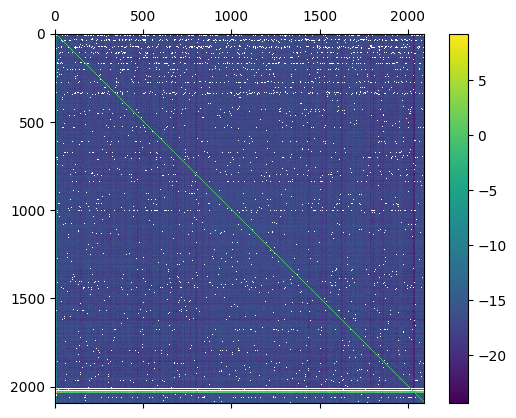

In [21]:
res = Jfm_stab.empty_container()
res.mat = Jfm.mat @ Jfm_stab_inv
res.matshow()

* $\tilde{A}^{-1} \cdot A$ - ok (left prec)
* $A \cdot \tilde{A}^{-1}$ - bad (right prec)

Q: Is GMRES left or right? 

A: Was right and didn't work, now left and works?

Solve  took: 0.3
True residual decrease: 0.0012885941245446295


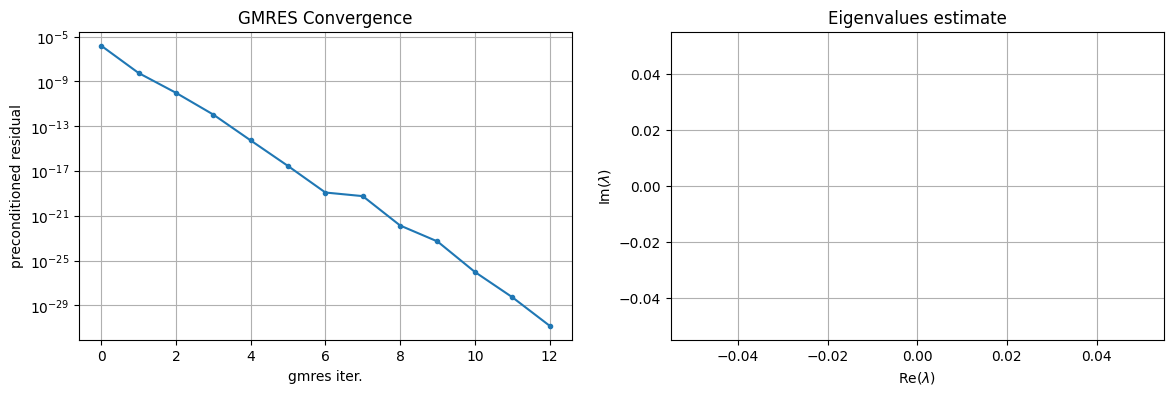

In [25]:
solve_petsc(Jfm.mat, Jfm_stab_inv, rhs=Jfm.local_rhs(rhs), tol=1e-25)